In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.8 MB/s eta 0:00:00:00:0100:01


Mapping giữa nhãn và số: {'barren land': 0, 'cropland': 1, 'forest': 2, 'open water': 3, 'residential land': 4, 'rice paddy': 5}
Số lượng lớp (N_CLASSES): 6
Kích thước ảnh: 1839 x 1547
Số lượng band: 13


I0000 00:00:1732338156.174597     158 service.cc:145] XLA service 0x7ab78c0034a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732338156.174654     158 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 19/348 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

I0000 00:00:1732338158.558349     158 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


348/348 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
Số lượng lớp sau khi thêm 'undefined': 7


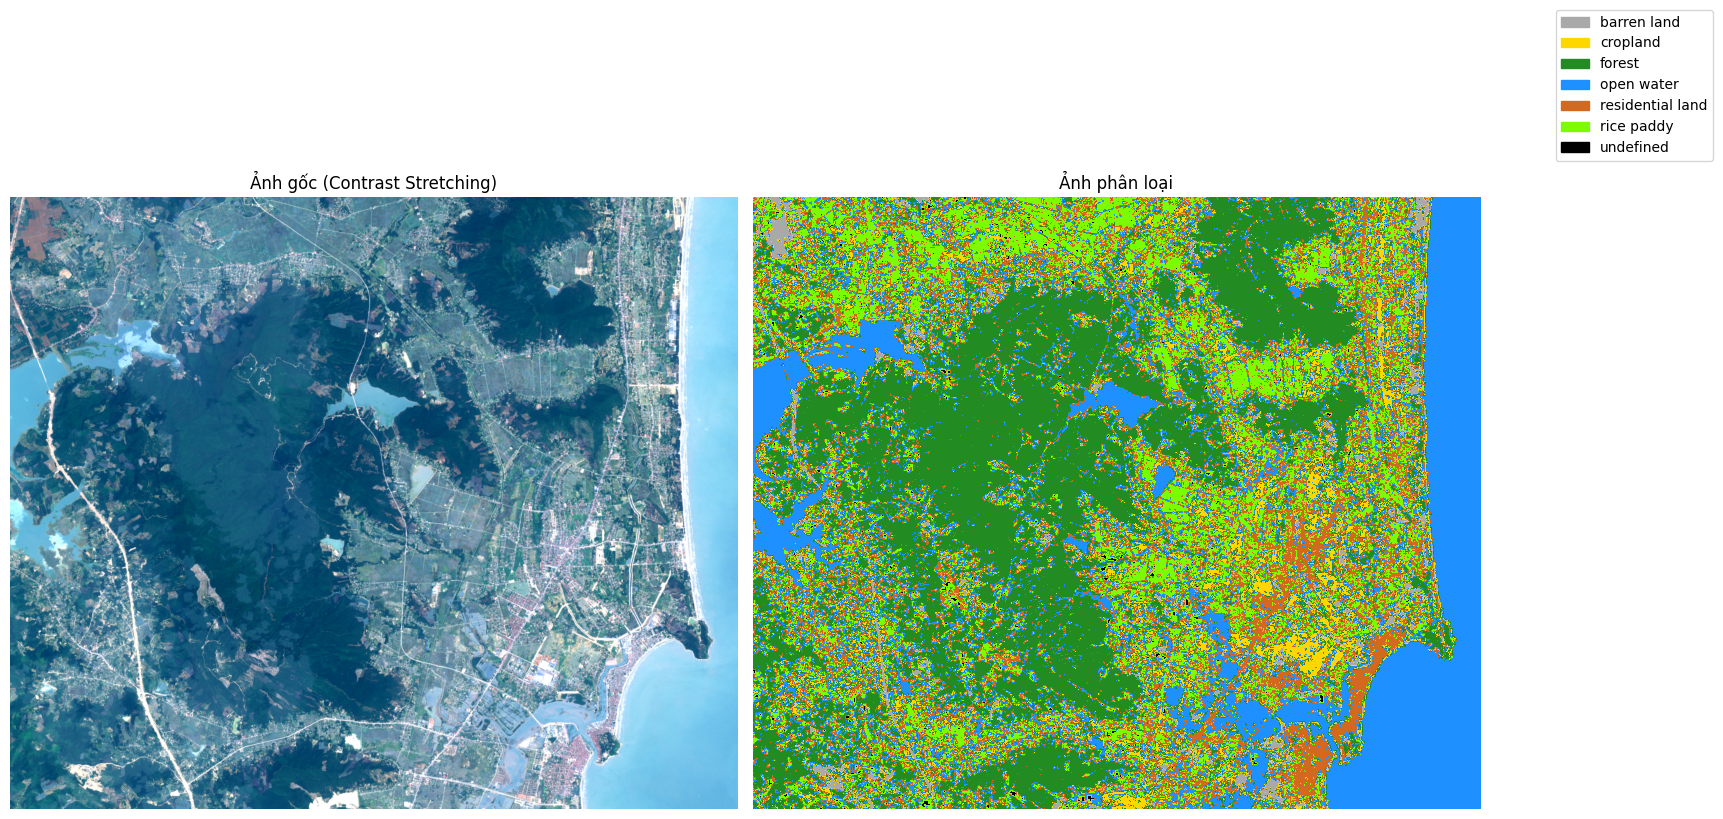

In [3]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from skimage import exposure
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

# Đường dẫn tới các file đã lưu
MODEL_PATH = '/kaggle/input/modelnew/trained_model.h5'
SCALER_PATH = '/kaggle/input/modelnew/scaler.pkl'
LABEL_ENCODER_PATH = '/kaggle/input/modelnew/label_encoder.pkl'
LABEL_MAPPING_PATH = '/kaggle/input/modelnew/label_mapping.pkl'

# Tải mô hình đã lưu
model = load_model(MODEL_PATH)

# Tải scaler
with open(SCALER_PATH, 'rb') as f:
    scaler = pickle.load(f)

# Tải LabelEncoder
with open(LABEL_ENCODER_PATH, 'rb') as f:
    le = pickle.load(f)

# Tải mapping giữa nhãn và số
with open(LABEL_MAPPING_PATH, 'rb') as f:
    label_mapping = pickle.load(f)

# In ra mapping giữa nhãn và số
print("Mapping giữa nhãn và số:", label_mapping)

# Cập nhật N_CLASSES
N_CLASSES = len(label_mapping)
print(f"Số lượng lớp (N_CLASSES): {N_CLASSES}")

# Danh sách các đặc trưng (FEATURES)
FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
            'B9', 'B10', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI',
            'NDMI', 'BSI', 'EVI', 'SAVI']

# Hàm reshape_input (nếu chưa định nghĩa)
def reshape_input(array):
    return array.reshape(array.shape[0], array.shape[1], 1)

# Đường dẫn tới file ảnh vệ tinh
IMAGE_PATH = '/kaggle/input/testimg10/test.tif'

# Đọc ảnh vệ tinh
image = rasterio.open(IMAGE_PATH)

# Lấy thông tin ảnh
height = image.height
width = image.width
band_count = image.count

print(f'Kích thước ảnh: {width} x {height}')
print(f'Số lượng band: {band_count}')

# Tạo dictionary cho các band (loại bỏ B1)
band_indices = {
    'B2': 2, 'B3': 3, 'B4': 4, 'B5': 5, 'B6': 6, 'B7': 7, 'B8': 8,
    'B8A': 9, 'B9': 10, 'B10': 11, 'B11': 12, 'B12': 13
}

# Đọc các band cần thiết và tính toán các chỉ số
bands_data = {}
for feature in FEATURES:
    if feature in band_indices:
        # Đọc band từ ảnh
        band_data = image.read(band_indices[feature]).astype('float32')
        bands_data[feature] = band_data.flatten()
    elif feature == 'NDVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        ndvi = (B8 - B4) / (B8 + B4 + 1e-8)
        bands_data[feature] = ndvi
    elif feature == 'NDWI':
        B3 = image.read(band_indices['B3']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndwi = (B3 - B8) / (B3 + B8 + 1e-8)
        bands_data[feature] = ndwi
    elif feature == 'NDBI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndbi = (B11 - B8) / (B11 + B8 + 1e-8)
        bands_data[feature] = ndbi
    elif feature == 'NDMI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        ndmi = (B8 - B11) / (B8 + B11 + 1e-8)
        bands_data[feature] = ndmi
    elif feature == 'BSI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B2 = image.read(band_indices['B2']).astype('float32').flatten()
        bsi = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2) + 1e-8)
        bands_data[feature] = bsi
    elif feature == 'EVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        B2 = image.read(band_indices['B2']).astype('float32').flatten()
        G = 2.5  # Gain factor
        C1 = 6.0  # Coefficient 1 for aerosol resistance
        C2 = 7.5  # Coefficient 2 for aerosol resistance
        L = 1.0  # Canopy background adjustment
        evi = G * (B8 - B4) / (B8 + C1 * B4 - C2 * B2 + L + 1e-8)
        bands_data[feature] = evi
    elif feature == 'SAVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        L_savi = 0.5  # Soil adjustment factor
        savi = ((B8 - B4) * (1 + L_savi)) / (B8 + B4 + L_savi + 1e-8)
        bands_data[feature] = savi
    else:
        print(f"Chỉ số {feature} chưa được tính toán.")

# Tạo DataFrame cho dữ liệu đầu vào
image_input_df = pd.DataFrame(bands_data, columns=FEATURES)

# Áp dụng scaler đã tải
image_input_scaled = scaler.transform(image_input_df)

# Reshape dữ liệu
image_input = reshape_input(image_input_scaled)

# Dự đoán
batch_size = 8192  # Điều chỉnh nếu cần
image_predictions = model.predict(image_input, batch_size=batch_size)

# Lấy nhãn dự đoán và xác suất
max_probs = np.max(image_predictions, axis=1)
pred_labels = np.argmax(image_predictions, axis=1)

# Gán nhãn 'undefined' cho các pixel có xác suất thấp (nếu muốn)
undefined_threshold = 0.8  # Ngưỡng xác suất
undefined_label = N_CLASSES  # Gán nhãn mới cho 'undefined'

# Tạo mảng nhãn mới với 'undefined'
pred_labels_with_undefined = np.where(max_probs < undefined_threshold, undefined_label, pred_labels)

# Cập nhật N_CLASSES để bao gồm cả lớp 'undefined'
N_CLASSES += 1
print(f"Số lượng lớp sau khi thêm 'undefined': {N_CLASSES}")

# Tạo danh sách tên lớp
class_names = list(label_mapping.keys()) + ['undefined']

# Bảng màu - Đảm bảo đủ màu cho N_CLASSES
PALETTE = ['#A9A9A9', '#FFD700', '#228B22', '#1E90FF', '#D2691E', '#7CFC00', '#000000']  # Cập nhật nếu cần

# Tạo cmap và norm
cmap = ListedColormap(PALETTE)
norm = BoundaryNorm(range(N_CLASSES + 1), cmap.N)

# Reshape kết quả dự đoán về kích thước ảnh gốc
prediction_image = pred_labels_with_undefined.reshape((height, width))

# Hiển thị ảnh
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Ảnh gốc với Contrast Stretching
band_red = image.read(band_indices['B4'])
band_green = image.read(band_indices['B3'])
band_blue = image.read(band_indices['B2'])
rgb_image = np.dstack([band_red, band_green, band_blue])

# Áp dụng Contrast Stretching
p2, p98 = np.percentile(rgb_image, (2, 98))
rgb_image_contrast = exposure.rescale_intensity(rgb_image, in_range=(p2, p98))

axes[0].imshow(rgb_image_contrast)
axes[0].set_title("Ảnh gốc (Contrast Stretching)")
axes[0].axis('off')

# Ảnh phân loại
im = axes[1].imshow(prediction_image, cmap=cmap, norm=norm)
axes[1].set_title("Ảnh phân loại")
axes[1].axis('off')

# Chú thích
patches = [mpatches.Patch(color=PALETTE[i], label=class_names[i]) for i in range(N_CLASSES)]
fig.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()
